In [23]:
import pandas as pd
import hopsworks
import joblib
import os
from dotenv import load_dotenv

load_dotenv()

True

In [44]:
project_name = "naveen"
api_key = os.getenv("HOPSWORKS_API_KEY")

connection = hopsworks.login(project=project_name, api_key_value=api_key)
fs = connection.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/865430
Connected. Call `.close()` to terminate connection gracefully.


In [25]:
mr = connection.get_model_registry()
model = mr.get_model("iris", version=1)
model_dir = model.download()
model = joblib.load(model_dir + "/iris_model.pkl")

Connected. Call `.close()` to terminate connection gracefully.


In [46]:
feature_view = fs.get_feature_view(name="iris", version=1)

In [47]:
from PIL import Image

batch_data = feature_view.get_batch_data()

y_pred = model.predict(batch_data)

y_pred

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.60s) 


array(['Setosa', 'Versicolor', 'Virginica', 'Versicolor', 'Setosa',
       'Versicolor', 'Virginica', 'Versicolor', 'Setosa', 'Setosa',
       'Setosa', 'Setosa', 'Versicolor', 'Virginica', 'Setosa',
       'Virginica', 'Versicolor', 'Setosa', 'Versicolor', 'Versicolor',
       'Setosa', 'Versicolor', 'Setosa', 'Setosa', 'Versicolor',
       'Virginica', 'Virginica', 'Virginica', 'Virginica', 'Versicolor',
       'Versicolor', 'Setosa', 'Setosa', 'Virginica', 'Setosa',
       'Virginica', 'Setosa', 'Versicolor', 'Virginica', 'Versicolor',
       'Virginica', 'Setosa', 'Versicolor', 'Virginica', 'Versicolor',
       'Setosa', 'Versicolor', 'Versicolor', 'Virginica', 'Setosa',
       'Setosa', 'Virginica', 'Virginica', 'Versicolor', 'Versicolor',
       'Virginica', 'Versicolor', 'Versicolor', 'Versicolor', 'Setosa',
       'Virginica', 'Virginica', 'Virginica', 'Setosa', 'Virginica',
       'Setosa', 'Versicolor', 'Versicolor', 'Setosa', 'Setosa', 'Setosa',
       'Virginica', 'Versicol

In [48]:
batch_data

,sepal_length,sepal_width,petal_length,petal_width
0,5.700000,3.800000,1.700000,0.300000
1,5.600000,2.700000,4.200000,1.300000
2,6.300000,3.300000,6.000000,2.500000
3,6.000000,2.900000,4.500000,1.500000
4,5.000000,3.000000,1.600000,0.200000
...,...,...,...,...
149,5.367117,4.434446,1.374910,0.497858
150,5.732203,2.366797,3.115597,1.155345
151,7.768135,3.645254,4.881264,1.835901
152,7.332555,2.301353,5.379912,1.829956


In [49]:
flower = y_pred[y_pred.size-1]
flower_img = "assets/" + flower + ".png"
img = Image.open(flower_img)            

img.save("assets/latest_iris.png")

In [50]:
iris_fg = fs.get_feature_group(name="iris", version=1)
df = iris_fg.read()
df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.07s) 


,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.700000,3.800000,1.700000,0.300000,Setosa
1,5.600000,2.700000,4.200000,1.300000,Versicolor
2,6.300000,3.300000,6.000000,2.500000,Virginica
3,6.000000,2.900000,4.500000,1.500000,Versicolor
4,5.000000,3.000000,1.600000,0.200000,Setosa
...,...,...,...,...,...
149,5.367117,4.434446,1.374910,0.497858,Setosa
150,5.732203,2.366797,3.115597,1.155345,Versicolor
151,7.768135,3.645254,4.881264,1.835901,Virginica
152,7.332555,2.301353,5.379912,1.829956,Virginica


In [51]:
label = df.iloc[-1]["variety"]
label

'Setosa'

In [52]:
label_flower = "assets/" + label + ".png"

img = Image.open(label_flower)            

img.save("assets/actual_iris.png")

In [53]:
monitor_fg = fs.get_or_create_feature_group(name="iris_predictions",
                                  version=1,
                                  primary_key=["datetime"],
                                  description="Iris flower Prediction/Outcome Monitoring"
                                 )

In [54]:
from datetime import datetime
now = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")

data = {
    'prediction': [flower],
    'label': [label],
    'datetime': [now],
}
monitor_df = pd.DataFrame(data)
monitor_fg.insert(monitor_df)

Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: iris_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/865430/jobs/named/iris_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x1f79a2a22a0>, None)

In [55]:
history_df = monitor_fg.read()
history_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.34s) 


,prediction,label,datetime
0,Setosa,Setosa,"07/09/2024, 23:45:56"
1,Versicolor,Virginica,"07/09/2024, 23:57:17"
2,Setosa,Setosa,"07/10/2024, 00:05:59"


In [57]:
import dataframe_image as dfi

df_recent = history_df.tail(5)
 
# If you exclude this image, you may have the same iris_latest.png and iris_actual.png files
# If no files have changed, the GH-action 'git commit/push' stage fails, failing your GH action (last step)
# This image, however, is always new, ensuring git commit/push will succeed.
dfi.export(df_recent, 'assets/df_recent.png', table_conversion = 'matplotlib')

In [58]:
from sklearn.metrics import confusion_matrix

predictions = history_df[['prediction']]
labels = history_df[['label']]

results = confusion_matrix(labels, predictions)
print(results)

[[2 0 0]
 [0 0 0]
 [0 1 0]]


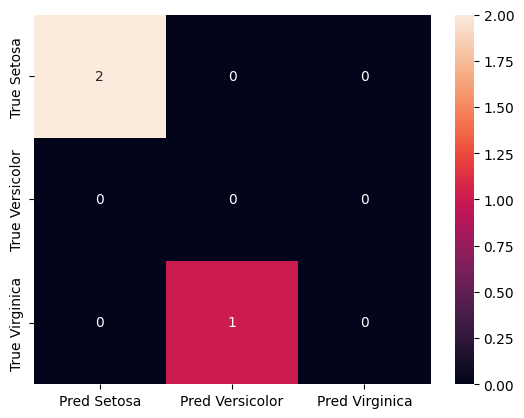

In [59]:
from matplotlib import pyplot
import seaborn as sns

# Only create the confusion matrix when our iris_predictions feature group has examples of all 3 iris flowers
if results.shape == (3,3):

    df_cm = pd.DataFrame(results, ['True Setosa', 'True Versicolor', 'True Virginica'],
                         ['Pred Setosa', 'Pred Versicolor', 'Pred Virginica'])

    cm = sns.heatmap(df_cm, annot=True)